## Defining the problem - clearly identifying the problem to be solved
Boston Housing - Regression problem


## Data Collection - gathering necessary data from various sources

Importing the necessary libraries and defining the functions

In [566]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [567]:
# functions required
# calculate test r-squared
def calculate_test_r2(y_pred, y_test):
    return r2_score(y_test, y_pred)

def get_test_size():
    return 0.2

def get_random_state():
    return 0

def get_k_fold_cv(k, random_state, X, y):
  kfold = KFold(n_splits = k, shuffle = True, random_state = random_state)
  spl = kfold.split(X)
  return spl

# forward selection to select features
def forward_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X.columns)
  remaining_features = list(X.columns)
  print(f"All Features: {all_features}")
  p = X.shape[1]
  m0 = np.mean(y)
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    print(f"K = {k}")
    for feature in remaining_features:
      print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
      temp_features.remove(feature)
      print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    print(f"Remaining features: {remaining_features}")

    X_train_subset = X_train.loc[:, selected_features]
    X_train_subset = sm.add_constant(X_train_subset)
    model = sm.OLS(y_train, X_train_subset).fit()
    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    print(f"Selected features: {selected_features}")
    print(f"r2-test: {r2_test}")



# backward selection to select features
def backward_selection(X, y, min_features=1):
    selected_features = list(X.columns)
    current_best_score = float('inf')

    while len(selected_features) > min_features:
        worst_feature = None
        for feature in selected_features:
            temp_features = [f for f in selected_features if f != feature]
            model = LinearRegression()
            model.fit(X[temp_features], y)
            predictions = model.predict(X[temp_features])
            score = mean_squared_error(y, predictions)

            if score < current_best_score:
                current_best_score = score
                worst_feature = feature

        if worst_feature is not None:
            selected_features.remove(worst_feature)
            print(f"Removed feature: {worst_feature}, Current MSE: {current_best_score}")
            current_best_score = float('inf')
        else:
            break
    return selected_features

# transformations
def log_transform(data):
  return np.log(data)

def square_root_transform(data):
  return np.sqrt(data)

def log_10_transform(data):
  return np.log10(data)

def inverse_transform(data):
  return 1/data

## Data Cleaning and pre-processing

In [568]:
BHname = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
          'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", delim_whitespace=True, names = BHname)
df.head()

/tmp/ipython-input-1225195446.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("housing.csv", delim_whitespace=True, names = BHname)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [569]:
print(f"Data Summary: \n{df.describe()}\n")
print(f"Data Shape: \n{df.shape}")

Data Summary: 
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.1

In [570]:
print(f"Nan values in data: \n{df.isna().sum()}\n")
print(f"Null values in data: \n{df.isnull().sum()}")

Nan values in data: 
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Null values in data: 
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


### EDA - Exploratory Data Analysis - Analysing data to identify patterns, outliers

In [571]:
# coefficient of variation for different features - a relative measurement of dispersion
cv = (df.std() / df.mean()) * 100
print(cv)

CRIM       238.037610
ZN         205.237586
INDUS       61.600874
CHAS       367.202814
NOX         20.890339
RM          11.179921
AGE         41.048344
DIS         55.485809
RAD         91.181152
TAX         41.284120
PTRATIO     11.730604
B           25.596162
LSTAT       56.437413
MEDV        40.816505
dtype: float64


In [572]:
# correlation matrix of features
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Univariate Analysis

Number of bins: 22


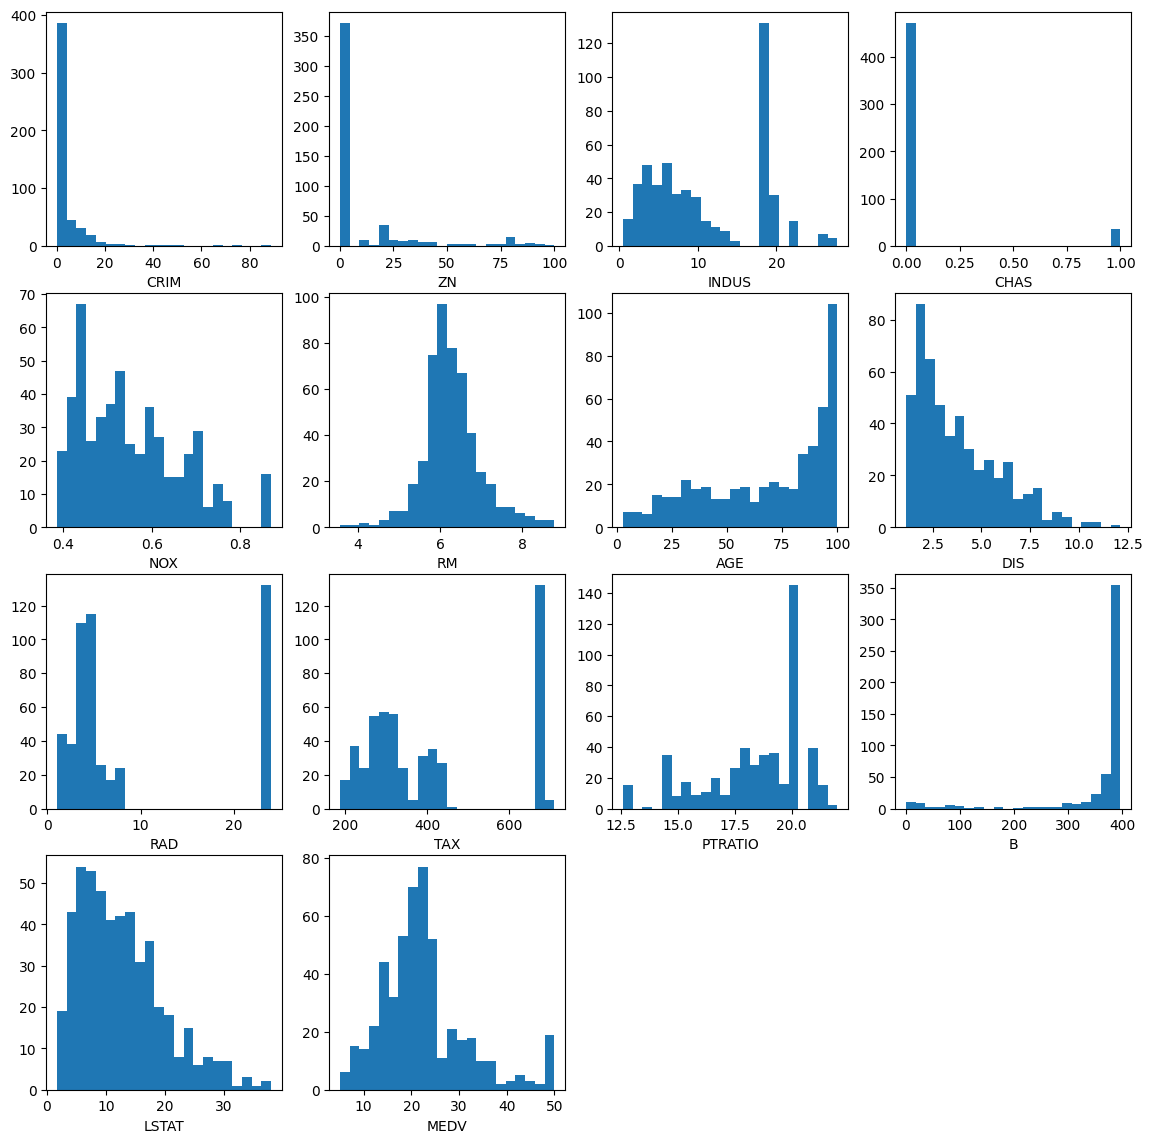

In [573]:
number_of_bins = round(np.sqrt(df.shape[0]))
print(f"Number of bins: {number_of_bins}")
plt.figure(figsize = (14, 14))
i = 1
for column in df.columns:
  plt.subplot(4, 4, i)
  plt.hist(df[column], bins = number_of_bins)
  plt.xlabel(column)
  i+=1
plt.show()

## regressor1 = model with all the features

In [574]:
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
X = sm.add_constant(X)
test_r2 = []
spl = get_k_fold_cv(5, 42, X, y)
for i, (train_index, test_index) in enumerate(spl):
  print(f"Fold: {i}")
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
  regressor1 = sm.OLS(y_train, X_train).fit()
  print(regressor1.summary())
  y_pred = regressor1.predict(X_test)
  test_r2.append(calculate_test_r2(y_pred, y_test))
mean_test_r2 = np.mean(test_r2)
print(f"Mean test R-Squared from 5 folds: {mean_test_r2}")

Fold: 0
Data size: (404, 14), (102, 14), (404,), (102,)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Mon, 25 Aug 2025   Prob (F-statistic):          6.21e-109
Time:                        17:48:21   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [575]:
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = get_test_size(), random_state = get_random_state())
spl = get_k_fold_cv(5, 42, X, y)
for i, (train_index, test_index) in enumerate(spl):
  print(f"\n*********** Fold: {i} ****************\n")
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
  features = forward_selection(X_train, y_train, X_test, y_test)


*********** Fold: 0 ****************

Data size: (404, 13), (102, 13), (404,), (102,)
All Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
K = 0
current feature: CRIM
Training features: ['const', 'CRIM']
Best R-Squared and R-Squared-train after adding current feature: -inf, 0.14446921351610564
Current best feature: CRIM
current feature: ZN
Training features: ['const', 'ZN']
Best R-Squared and R-Squared-train after adding current feature: 0.14446921351610564, 0.09579247649808165
Current best feature: CRIM
current feature: INDUS
Training features: ['const', 'INDUS']
Best R-Squared and R-Squared-train after adding current feature: 0.14446921351610564, 0.22141388488883906
Current best feature: INDUS
current feature: CHAS
Training features: ['const', 'CHAS']
Best R-Squared and R-Squared-train after adding current feature: 0.22141388488883906, 0.0363443624894183
Current best feature: INDUS
current feature: NOX
Training features: ['c

### regressor1 (with all features) => test r-squared = 71.52%

## Detect Outliers, High Leverage Points and Influence

### Detect Outliers

In [576]:
raise Exception("exception occurred")
# Outliers detection using boxplot
boxplot = plt.boxplot(df['MEDV'])
plt.show()

Exception: exception occurred

In [ ]:
outliers = [flier.get_ydata() for flier in boxplot["fliers"]][0]
print(max(outliers))
print(min(outliers))
print(outliers)
print(len(outliers))
outliers_indices = df[df['MEDV'].isin(outliers)].index
print(outliers_indices)

In [ ]:
print(df.shape)
df1 = df[~df['MEDV'].isin(outliers)]
print(df1.shape)
y1 = df1['MEDV']
X1 = df1.loc[:, df1.columns != 'MEDV']
print(y1.shape)
print(X1.shape)
X1 = sm.add_constant(X1)
print(y1.shape)
print(X1.shape)
X1.head(2)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = get_test_size(), random_state = get_random_state())
regressor2 = sm.OLS(y1_train, X1_train).fit()
print(regressor2.summary())
y1_pred = regressor2.predict(X1_test)
calculate_test_r2(y1_pred, y1_test)

### regressor2 (removing outliers detected by boxplot) => test r-squared = 74.43%, but 40 rows are removed

In [ ]:
# Outliers detection using Z-scores
outliers_zscore = np.abs(regressor1.outlier_test()['bonf(p)']) < 0.05
print(outliers_zscore[outliers_zscore == True])
print(len(outliers_zscore[outliers_zscore == True]))
outliers_indices = outliers_zscore[outliers_zscore == True].index
print(outliers_indices)

In [ ]:
print(df.shape)
df2 = df.drop(index = outliers_indices)
print(df2.shape)
y2 = df2['MEDV']
X2 = df2.loc[:, df2.columns != 'MEDV']
X2 = sm.add_constant(X2)
print(y2.shape)
print(X2.shape)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = get_test_size(), random_state = get_random_state())
regressor3 = sm.OLS(y2_train, X2_train).fit()
print(regressor3.summary())
y2_pred = regressor3.predict(X2_test)
calculate_test_r2(y2_pred, y2_test)

### regressor3 (removing outliers detected by Z-scores) => test r-squared = 71.61%, 3 rows are removed

### Check for high leverage points

In [ ]:
# High Leverage points check using Leverage statistics (eg. Hat Matrix)
regressor4 = sm.OLS(y, X).fit()
influence = regressor4.get_influence()
leverage = influence.hat_matrix_diag
leverage_points = np.where(leverage > np.mean(leverage) + 2 * np.std(leverage))
print(leverage_points[0])
print(len(leverage_points[0]))

In [ ]:
print(df.shape)
df3 = df.drop(leverage_points[0], axis = 0)
print(df3.shape)
y3 = df3['MEDV']
X3 = df3.loc[:, df3.columns != 'MEDV']
X3 = sm.add_constant(X3)
print(y3.shape)
print(X3.shape)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = get_test_size(), random_state = get_random_state())
regressor5 = sm.OLS(y3_train, X3_train).fit()
print(regressor5.summary())
y3_pred = regressor5.predict(X3_test)
calculate_test_r2(y3_pred, y3_test)

### regressor5 (removing high-leverage-points detected by hat-matrix) => test r-squared = 73.12%, but 17 rows are removed

In [ ]:
# High Leverage check using Cook's distance
cook_distance = regressor4.get_influence().cooks_distance[0]
print(4 / df.shape[1])
influential_observations = np.where(cook_distance > 4 / df.shape[1])
print(influential_observations)

### Detecting High-leverage-points using Cook's distance resulted in no data

### Calculate Influence using DFFITS and DFBETAS

In [ ]:
# Influence calculation using DFFITS and DFBETAS
dffits = regressor4.get_influence().dffits[0]
dfbetas = regressor4.get_influence().dfbetas
influential_dffits = np.where(np.abs(dffits) > 2 * np.sqrt(df.shape[1] * regressor4.df_model / regressor4.df_resid))
coefficient_index = 0  # Index of the coefficient to analyze
influential_dfbetas = np.where(np.abs(dfbetas[:, coefficient_index]) > 2 / np.sqrt(df.shape[1]))
print(influential_dffits[0])
print(influential_dfbetas[0])

In [ ]:
df4 = df.drop(influential_dffits[0], axis = 0)
print(df4.shape)
y4 = df4['MEDV']
X4 = df4.loc[:, df4.columns != 'MEDV']
X4 = sm.add_constant(X4)
print(y4.shape)
print(X4.shape)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = get_test_size(), random_state = get_random_state())
regressor6 = sm.OLS(y4_train, X4_train).fit()
print(regressor6.summary())
y4_pred = regressor6.predict(X4_test)
calculate_test_r2(y4_pred, y4_test)

### regressor6 (removing influence-points detected by DFFITS) => test r-squared = 69.56%, 1 row is removed

In [ ]:
df5 = df.drop(influential_dfbetas[0], axis = 0)
print(df5.shape)
y5 = df5['MEDV']
X5 = df5.loc[:, df5.columns != 'MEDV']
X5 = sm.add_constant(X5)
print(y5.shape)
print(X5.shape)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = get_test_size(), random_state = get_random_state())
regressor7 = sm.OLS(y5_train, X5_train).fit()
print(regressor7.summary())
y5_pred = regressor7.predict(X5_test)
calculate_test_r2(y5_pred, y5_test)

### regressor7 (removing influence-points detected by DFBETAS) => test r-squared = 74.56%, 3 rows are removed

## Checking Multicollinearity using VIF

In [ ]:
print(X.columns)
X_vif1 = X.drop('const', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif1.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif1.values, i)
                          for i in range(len(X_vif1.columns))]

print(vif_data)

In [ ]:
X_vif2 = X_vif1.drop('PTRATIO', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif2.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif2.values, i)
                          for i in range(len(X_vif2.columns))]

print(vif_data)

In [ ]:
X_vif3 = X_vif2.drop('NOX', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif3.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif3.values, i)
                          for i in range(len(X_vif3.columns))]

print(vif_data)

In [ ]:
X_vif4 = X_vif3.drop('TAX', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif4.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif4.values, i)
                          for i in range(len(X_vif4.columns))]

print(vif_data)

In [ ]:
X_vif5 = X_vif4.drop('RM', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif5.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif5.values, i)
                          for i in range(len(X_vif5.columns))]

print(vif_data)

In [ ]:
X_vif6 = X_vif5.drop('B', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif6.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif6.values, i)
                          for i in range(len(X_vif6.columns))]

print(vif_data)

In [ ]:
X_vif7 = X_vif6.drop('AGE', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif7.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif7.values, i)
                          for i in range(len(X_vif7.columns))]

print(vif_data)

In [ ]:
X_vif8 = X_vif7.drop('INDUS', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif8.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif8.values, i)
                          for i in range(len(X_vif8.columns))]

print(vif_data)

### 'PTRATIO', 'NOX', 'TAX', 'RM', 'B', 'AGE', 'INDUS' has VIF values much larger than 5. We will remove these features and rebuild our model

In [ ]:
y6 = df['MEDV']
X6 = df.drop(columns = ['PTRATIO', 'NOX', 'TAX', 'RM', 'B', 'AGE', 'INDUS'])
print(y6.shape)
print(X6.shape)
X6 = sm.add_constant(X6)
print(X6.shape)
print(X6.head(2))
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = get_test_size(), random_state = get_random_state())
regressor8 = sm.OLS(y6_train, X6_train).fit()
print(regressor8.summary())
y6_pred = regressor8.predict(X6_test)
calculate_test_r2(y6_pred, y6_test)

In [ ]:
y_fs = df['MEDV']
X_fs = df.loc[: , df.columns != 'MEDV']
print(y_fs.shape)
print(X_fs.shape)
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size = get_test_size(), random_state = get_random_state())
forward_selection_results = forward_selection(X_fs_train, y_fs_train)
print(forward_selection_results)

In [ ]:
y7 = df['MEDV']
X7 = df.drop(columns = ['ZN', 'CRIM', 'RAD', 'TAX', 'AGE', 'INDUS'])
print(y7.shape)
print(X7.shape)
X7 = sm.add_constant(X7)
print(X7.shape)
print(X7.head(2))
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = get_test_size(), random_state = get_random_state())
regressor9 = sm.OLS(y7_train, X7_train).fit()
print(regressor9.summary())
y7_pred = regressor9.predict(X7_test)
calculate_test_r2(y7_pred, y7_test)

In [ ]:
y_bs = df['MEDV']
X_bs = df.loc[: , df.columns != 'MEDV']
print(y_bs.shape)
print(X_bs.shape)
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_bs, y_bs, test_size = get_test_size(), random_state = get_random_state())
backward_selection_results = backward_selection(X_bs_train, y_bs_train)
print(backward_selection_results)